<a href="https://colab.research.google.com/github/Abdoul1996/Alzheimer_Classification/blob/main/Siham_CSC671_871FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification of Amyloid PET images into healthy and Alzheimer's Disease (AD) categories.
**Classes Include**:
- CN : Cognitively normal
- MCI : Mild cognitive impairment
- AD : Alzheimer's disease

In [ ]:
import os
import numpy as np
from numpy import expand_dims
import cv2
import nibabel as nib
import matplotlib.pyplot as plt
import glob
import pandas as pd
from pathlib import Path
from google.colab import drive
from sklearn.model_selection import train_test_split
from IPython.display import clear_output
from skimage.color import gray2rgb
from sklearn.utils import shuffle
from skimage.transform import resize
import warnings
import torch
from torchvision import models, transforms
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

In [ ]:
!pip install pydicom

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 74.5 MB/s eta 0:00:00


In [ ]:
import pydicom

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!apt-get update -y && apt-get install -y fuse lsb-release; \
    curl -L -O https://github.com/GoogleCloudPlatform/gcsfuse/releases/download/v0.41.12/gcsfuse_0.41.12_amd64.deb; \
    dpkg --install gcsfuse_0.41.12_amd64.deb; \
    apt-get update; \
    apt-get clean;

In [ ]:
from google.colab import auth
auth.authenticate_user()

In [ ]:
project_id = 'sfsu-378805'
bucket_name = 'csc-509-image-files'
!gcloud config set project {project_id}

Are you sure you wish to set property [core/project] to sfsu-378805?

Do you want to continue (Y/n)?  y

Updated property [core/project].


In [ ]:
!gsutil ls

You are attempting to access protected data with no configured
credentials. Please visit https://cloud.google.com/console#/project
and sign up for an account, and then run the "gcloud auth login"
command to configure gsutil to use these credentials.


In [ ]:
!mkdir images

In [ ]:
!gcsfuse --implicit-dirs csc-509-image-files images

2024/12/09 04:20:31.069785 Start gcsfuse/0.41.12 (Go version go1.18.4) for app "" using mount point: /content/images
2024/12/09 04:20:31.084578 Opening GCS connection...
2024/12/09 04:20:32.714846 Mounting file system "csc-509-image-files"...
2024/12/09 04:20:32.715513 File system has been successfully mounted.


In [ ]:
!ls images/

Archive				Module0_UPENNGBM  Module1_BraTS.tar.bz2  Module2_ADNI_New
Module0_DataCuration		Module1_ADNI	  Module1_PET
Module0_MRI_PET_Classification	Module1_BraTS	  Module2_ADNI


Create the training, validation and test ids

In [ ]:
DATA_PATH = Path('/content/images/Module2_ADNI/')

In [ ]:
os.listdir(Path(DATA_PATH, 'CSVS',))

['ADNI_AMYPet_withClinicalData_01122023.csv',
 'ADNI_AmyPET_MiddleSlices_ClinicalData.csv',
 'ADNI_ClinicalData.csv',
 'ADNI_FDGPET_FILEPATH_TO_DICOM_FOLDER_ClinicalData.csv',
 'ADNI_MissingClinicalData.csv',
 'ADNI_PET_MiddleSlices_ClinicalData.csv']

In [ ]:
# Read Amyloid PET
data_df = pd.read_csv(Path(DATA_PATH,'CSVS/ADNI_AMYPet_withClinicalData_01122023.csv'))
data_df = data_df[data_df['SLICE_NUM'] == 48].reset_index(drop = True)
print(len(data_df))
data_df.head()

445


Unnamed: 0                             FILEPATH_MIDDLE_SLICES  SLICE_NUM  \
0           0  images/Module2_ADNI/PET_1/002_S_4447/AV45_Core...         48   
1           1  images/Module2_ADNI/PET_1/002_S_4447/AV45_Core...         48   
2           2  images/Module2_ADNI/PET_1/002_S_4447/AV45_Core...         48   
3           3  images/Module2_ADNI/PET_1/002_S_4447/AV45_Core...         48   
4           4  images/Module2_ADNI/PET_1/003_S_4288/AV45_Core...         48   

                                         AMYPET_TYPE     Subject  \
0  AV45_Coreg,_Avg,_Std_Img_and_Vox_Siz,_Uniform_...  002_S_4447   
1  AV45_Coreg,_Avg,_Std_Img_and_Vox_Siz,_Uniform_...  002_S_4447   
2  AV45_Coreg,_Avg,_Std_Img_and_Vox_Siz,_Uniform_...  002_S_4447   
3  AV45_Coreg,_Avg,_Std_Img_and_Vox_Siz,_Uniform_...  002_S_4447   
4  AV45_Coreg,_Avg,_Std_Img_and_Vox_Siz,_Uniform_...  003_S_4288   

  Image Data ID Group Sex  Age  Visit Modality  \
0       I285198  EMCI   F   68     23      PET   
1       I285200  EMCI   F   68     23      PET   
2       I285197  EMCI   F   68     23      PET   
3       I285199  EMCI   F   68     23      PET   
4       I272168    CN   F   73     23      PET   

                                         Description       Type    Acq Date  \
0  AV45 Coreg, Avg, Std Img and Vox Siz, Uniform ...  Processed   2/13/2012   
1                         AV45 Co-registered Dynamic  Processed   2/13/2012   
2  AV45 Coreg, Avg, Standardized Image and Voxel ...  Processed   2/13/2012   
3                       AV45 Co-registered, Averaged  Processed   2/13/2012   
4  AV45 Coreg, Avg, Standardized Image and Voxel ...  Processed  12/06/2011   

  Format Downloaded  
0    DCM  9/16/2021  
1    DCM  9/16/2021  
2    DCM  9/16/2021  
3    DCM  9/16/2021  
4    DCM  9/16/2021

In [ ]:
data_df['FOLDERPATH_MIDDLE_SLICES'] = data_df['FILEPATH_MIDDLE_SLICES'].str.rsplit('/', n = 1).str[0]

In [ ]:
# Let's check the groups
data_df['Group'].unique()
data_df[['Image Data ID', 'Group']].groupby(by = 'Group').count()

Image Data ID
Group               
AD                64
CN               140
EMCI             129
LMCI              36
MCI                8
SMC               68

In [ ]:
# Keep only 3 classes and filter out rest from df
data_df = data_df[['Image Data ID', 'FILEPATH_MIDDLE_SLICES', 'FOLDERPATH_MIDDLE_SLICES', 'Group' ]]
data_df_filt = data_df[data_df['Group'].isin(['AD', 'CN', 'EMCI'])].reset_index(drop = True)


print("Number of patient ids:", len(data_df_filt))
data_df_filt.head()

Number of patient ids: 333


Image Data ID                             FILEPATH_MIDDLE_SLICES  \
0       I285198  images/Module2_ADNI/PET_1/002_S_4447/AV45_Core...   
1       I285200  images/Module2_ADNI/PET_1/002_S_4447/AV45_Core...   
2       I285197  images/Module2_ADNI/PET_1/002_S_4447/AV45_Core...   
3       I285199  images/Module2_ADNI/PET_1/002_S_4447/AV45_Core...   
4       I272168  images/Module2_ADNI/PET_1/003_S_4288/AV45_Core...   

                            FOLDERPATH_MIDDLE_SLICES Group  
0  images/Module2_ADNI/PET_1/002_S_4447/AV45_Core...  EMCI  
1  images/Module2_ADNI/PET_1/002_S_4447/AV45_Core...  EMCI  
2  images/Module2_ADNI/PET_1/002_S_4447/AV45_Core...  EMCI  
3  images/Module2_ADNI/PET_1/002_S_4447/AV45_Core...  EMCI  
4  images/Module2_ADNI/PET_1/003_S_4288/AV45_Core...    CN

In [ ]:
# check if df is filtered and print out count of each class
data_df_filt[['Image Data ID', 'Group']].groupby(by = 'Group').count()

Image Data ID
Group               
AD                64
CN               140
EMCI             129

In [ ]:
# Split into training, validation set and test set
ids = data_df_filt['Image Data ID'].unique()

# Here we have selected the size of test set as 15 %
train_ids, test_ids = train_test_split(ids,test_size=0.15)

# Create validation ids by further splitting the train ids, we again use 15 % as size of validation set. Validation set is also referred to as tuning set.
train_ids, val_ids = train_test_split(train_ids,test_size=0.15)

In [ ]:
# print the number of patients ids in train, validation and test set
print(f'There are {len(train_ids)} patient ids in training set')
print(f'There are {len(val_ids)} patient ids in validation set')
print(f'There are {len(test_ids)} patient ids in test set')

There are 240 patient ids in training set
There are 43 patient ids in validation set
There are 50 patient ids in test set


In [ ]:
data_df_filt['Split'] = np.where(data_df_filt['Image Data ID'].isin(train_ids), 'Train', '')
data_df_filt['Split'] = np.where(data_df_filt['Image Data ID'].isin(val_ids), 'Validation', data_df_filt['Split'])
data_df_filt['Split'] = np.where(data_df_filt['Image Data ID'].isin(test_ids), 'Test', data_df_filt['Split'])

data_df_filt[['Image Data ID', 'Group', 'Split']].groupby(by = ['Split', 'Group']).count()

Image Data ID
Split      Group               
Test       AD                 8
           CN                21
           EMCI              21
Train      AD                46
           CN               101
           EMCI              93
Validation AD                10
           CN                18
           EMCI              15

In [ ]:
# Let's create a function to normalize the image between 0 and 1 and change label to 0 and 1
def normalize(image, label, percentile = 0.001,
              eps = 0.0000001):


    img_array = np.ndarray.flatten(image)
    min_img, max_img = np.quantile(img_array, percentile), np.quantile(img_array, 1-percentile)
    img_normalized = ((image-min_img)/(max_img-min_img+eps)*255).astype(np.uint8)
    input_image = torch.tensor(img_normalized, dtype=torch.float32)/255

    if label == 'CN':
      input_label = 0
    elif label == 'EMCI':
      input_label = 1
    elif label == 'AD':
        input_label = 2
    else:
        raise ValueError(f"Unexpected label: {label}")


    return input_image, input_label

In [ ]:
# Let's create a function read dicoms and sort by slice number

def read_all_dicom_slices(dicom_directory):
    """
    Will read in the images from a single dicom folder and return a dictionary of
    those images with the key as the presumed slice number, and the value being the pixel array.

    dicom_directory: Path or string that leads to the folder containing the slices

    """
    dicom_image_dict = {}
    for image in glob.glob(str(Path(dicom_directory, '*'))):
      key = image.split('/')[-1].split('_')[-3]
      dicom_image_dict[key]= pydicom.dcmread(image)
    return dicom_image_dict

In [ ]:
# Let's create a function to create numpy arrays using the above 2 functions

def create_numpy_array(df):
  X = []
  Y = []
  for i in range(len(df)):
    print("i:"+ str(i))
    dicom_volume = read_all_dicom_slices(df['FOLDERPATH_MIDDLE_SLICES'][i])
    print(dicom_volume)
    keys_sorted = [str(x) for x in sorted([int(x) for x in list(dicom_volume.keys())])]
    print(keys_sorted)
    keys_filt = [46, 47, 48, 49, 50] # picks up 5 slices per image
    for key in keys_filt: # iterates through the dictionary, while the enumerate function keeps track of the index with j
        value = dicom_volume[str(key)]
        image = value.pixel_array
        label = df['Group'][i]
        new_image, new_label = normalize(image, label)
        X.append(new_image)
        Y.append(new_label)
  return np.asarray(X), np.asarray(Y)

In [ ]:
# Let's create numpy arrays for training, validation and test sets using the above 3 functions
# X_train, Y_train = create_numpy_array(data_df_filt[data_df_filt['Split'] == 'Train'].reset_index(drop = True))
# X_val, Y_val = create_numpy_array(data_df_filt[data_df_filt['Split'] == 'Validation'].reset_index(drop = True))
# X_test, Y_test = create_numpy_array(data_df_filt[data_df_filt['Split'] == 'Test'].reset_index(drop = True))

In [ ]:
# Let's save the train, validation and test arrays to a path in your drive
# np.save('/content/drive/MyDrive/Numpy_ADNI/AmyPET_train_images.npy', X_train) # Enter the path where you will save the file
# np.save('/content/drive/MyDrive/Numpy_ADNI/AmyPET_val_images.npy', X_val)
# np.save('/content/drive/MyDrive/Numpy_ADNI/AmyPET_test_images.npy', X_test)
# np.save('/content/drive/MyDrive/Numpy_ADNI/AmyPET_train_label.npy', Y_train)
# np.save('/content/drive/MyDrive/Numpy_ADNI/AmyPET_val_label.npy', Y_val)
# np.save('/content/drive/MyDrive/Numpy_ADNI/AmyPET_test_label.npy', Y_test)

In [ ]:
# Let's load the train, validation and test arrays
X_train = np.load('/content/drive/MyDrive/Numpy_ADNI/AmyPET_train_images.npy', allow_pickle=True)
X_val = np.load('/content/drive/MyDrive/Numpy_ADNI/AmyPET_val_images.npy', allow_pickle=True)
X_test = np.load('/content/drive/MyDrive/Numpy_ADNI/AmyPET_test_images.npy', allow_pickle=True)
Y_train = np.load('/content/drive/MyDrive/Numpy_ADNI/AmyPET_train_label.npy', allow_pickle=True)
Y_val = np.load('/content/drive/MyDrive/Numpy_ADNI/AmyPET_val_label.npy', allow_pickle=True)
Y_test = np.load('/content/drive/MyDrive/Numpy_ADNI/AmyPET_test_label.npy', allow_pickle=True)

In [ ]:
# Converting grayscale images to RGB
X_train = np.array([gray2rgb(X_train[i]) for i in range(len(X_train))])
X_val = np.array([gray2rgb(X_val[i]) for i in range(len(X_val))])
X_test = np.array([gray2rgb(X_test[i]) for i in range(len(X_test))])

In [ ]:
X_train, Y_train = shuffle(X_train, Y_train, random_state = 0)
X_val, Y_val = shuffle(X_val, Y_val, random_state = 0)
X_test, Y_test = shuffle(X_test, Y_test, random_state = 0)

In [ ]:
# Let's confirm the size of the training and validation arrays
print(f'There are {len(X_train)} images in training set')
print(f'There are {len(X_val)} images in validation set')
print(f'There are {len(X_test)} images in test set')

There are 1200 images in training set
There are 215 images in validation set
There are 250 images in test set


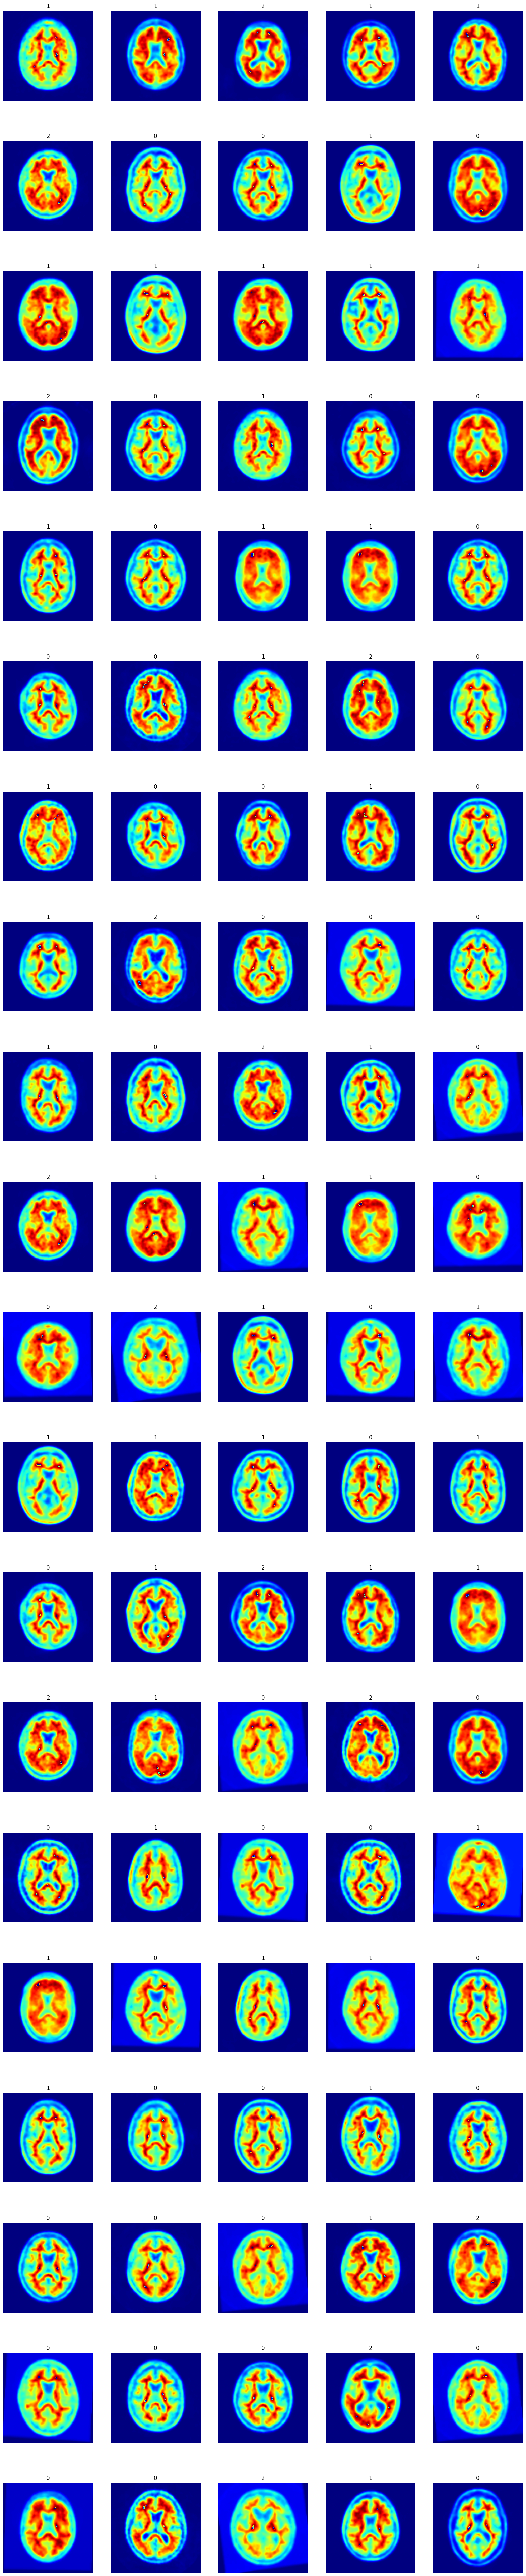

In [ ]:
plt.figure(figsize = (20, 100))
for i in range(100):

    plt.subplot(20,5, i+1)
    plt.imshow(X_train[i][:,:,0], cmap = 'jet')
    plt.axis('off')
    plt.title(Y_train[i])

In [ ]:
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train).permute(0, 3, 1, 2).float()
Y_train_tensor = torch.tensor(Y_train).long()
X_val_tensor = torch.tensor(X_val).permute(0, 3, 1, 2).float()
Y_val_tensor = torch.tensor(Y_val).long()
X_test_tensor = torch.tensor(X_test).permute(0, 3, 1, 2).float()
Y_test_tensor = torch.tensor(Y_test).long()

In [ ]:
from math import degrees
# Define a method for data augmentation, to have more data for class 'AD' and balance the dataset
data_augmentation = nn.Sequential(
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10)
)
def augment(dataset):
  augmented = []
  for tensor in dataset:
    augmented.append(data_augmentation(tensor))
  return torch.stack(augmented)

In [ ]:
# Build Model function
def build_model():
    # use pretrained model VGG16 as a starter
    base_model = models.vgg16(pretrained=True)
    # freeze all the layers except the classfier for feature extraction
    for param in base_model.features.parameters():
        param.requires_grad = False
    # Replace the classifier head with a dense layer for 3 classes and dropout
    base_model.classifier = nn.Sequential(
      nn.Linear(25088, 256),
      nn.ReLU(),
      nn.Dropout(p=0.5),
      nn.Linear(256, 3)
    )
    return base_model
    # summarize model

In [ ]:
# Training Function
def train_model(model, X_train_tensor, Y_train_tensor, X_val_tensor, Y_val_tensor,
                batch_size, optimizer_fn):
    # Load data in batches
    train_loader = DataLoader(TensorDataset(X_train_tensor, Y_train_tensor), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(TensorDataset(X_val_tensor, Y_val_tensor), batch_size=batch_size)

    lossFunc = nn.CrossEntropyLoss() # define loss function
    optimizer = optimizer_fn(model.parameters(), lr=0.0001, weight_decay=1e-4) # setup the optimizer
    train_loss, val_loss = [], []
    train_acc, val_acc = [], []

    early_stopping_patience = 5
    best_val_loss = float('inf')
    patience_counter = 0

    correct = 0
    total = 0

    for epoch in range(5):
        model.train()
        epoch_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = lossFunc(outputs, y_batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)
        train_loss.append(epoch_loss / len(train_loader))
        train_acc.append(correct / total)

        # Validation
        model.eval()
        val_epoch_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                outputs = model(X_batch)
                loss = lossFunc(outputs, y_batch)
                val_epoch_loss += loss.item()

                # Calculate validation accuracy
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == y_batch).sum().item()
                total += y_batch.size(0)
        val_loss.append(val_epoch_loss / len(val_loader))
        val_acc.append(correct / total)

        print(f"Epoch {epoch+1}/5, Train Loss: {train_loss[-1]:.4f}, "
              f"Val Loss: {val_loss[-1]:.4f}, Train Acc: {train_acc[-1]:.4f}, "
              f"Val Acc: {val_acc[-1]:.4f}")

        # Stop early if no more learning
        if val_loss[-1] < best_val_loss:
            best_val_loss = val_loss[-1]
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= early_stopping_patience:
                print("Early stopping triggered.")
                break
    return train_loss, val_loss, train_acc, val_acc


In [ ]:
def hyperparameter_search(X_train_tensor, Y_train_tensor, X_val_tensor, Y_val_tensor):

    optimizers = [torch.optim.SGD, torch.optim.Adam]
    batch_sizes = [32, 64]
    best_params = None
    best_val_loss = float('inf')

    for opt in optimizers:
      for bs in batch_sizes:
          print(f"Testing: LR=0.0001, Optimizer={opt.__name__}, BS={bs}, Epochs=5, Dropout=0.5")
          model = build_model()
          train_loss, val_loss, train_acc, val_acc = train_model(model, X_train_tensor, Y_train_tensor,
                                             X_val_tensor, Y_val_tensor,
                                             batch_size=bs, optimizer_fn=opt)
          if val_loss[-1] < best_val_loss:
            best_val_loss = val_loss[-1]
            best_params = (opt, bs)
    print(f"Best Parameters: {best_params}")
    return best_params


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)  # Forward pass
            _, preds = torch.max(outputs, 1)  # Get predicted classes
            all_preds.extend(preds.cpu().numpy())  # Store predictions
            all_labels.extend(y_batch.cpu().numpy())  # Store true labels

    # Convert to NumPy arrays
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # Compute accuracy
    accuracy = (all_preds == all_labels).mean() * 100
    print(f"Accuracy: {accuracy:.2f}%")

    # Compute and display confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

    # Display classification report
    report = classification_report(all_labels, all_preds, target_names=['Class 0', 'Class 1', 'Class 2'])
    print("Classification Report:")
    print(report)



In [ ]:
# Augment the training data for the 'AD' class (label 2)
ad_indices = torch.where(Y_train_tensor == 2)[0]  # Get indices of the 'AD' class
ad_data = X_train_tensor[ad_indices]  # Filter 'AD' data
ad_labels = Y_train_tensor[ad_indices]  # Corresponding labels

print(f"Original 'AD' data size: {len(ad_data)}")
print(f"Original 'EMCI' data size: {len(X_train_tensor[torch.where(Y_train_tensor == 1)[0]])}")
print(f"Original 'CN' data size: {len(X_train_tensor[torch.where(Y_train_tensor == 0)[0]])}")

# Apply data augmentation directly
augmented_data = augment(ad_data)
print(f"Augmented 'AD' data size: {len(augmented_data)}")

# Concatenate the augmented 'AD' data with the original dataset
X_train_tensor = torch.cat((X_train_tensor, augmented_data), dim=0)
Y_train_tensor = torch.cat((Y_train_tensor, torch.full((len(augmented_data),), 2, dtype=torch.long)), dim=0)

print(f"Training data size after augmentation: {len(X_train_tensor)}")

Original 'AD' data size: 235
Original 'EMCI' data size: 505
Original 'CN' data size: 460
Augmented 'AD' data size: 235
Training data size after augmentation: 1435


In [ ]:
ad_indices = torch.where(Y_train_tensor == 2)[0]  # Get indices of the 'AD' class
ad_data = X_train_tensor[ad_indices]
print(f"Current 'AD' data size: {len(ad_data)}")

Current 'AD' data size: 470


In [ ]:
# Build model
model = build_model()
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
# Perform hyperparameter search
best_params = hyperparameter_search(X_train_tensor, Y_train_tensor, X_val_tensor, Y_val_tensor)
best_optimizer, best_bs = best_params


print(f"Training the model with the best parameters: {best_params}")

Testing: LR=0.00001, Optimizer=SGD, BS=32, Epochs=14, Dropout=0.5


In [ ]:
# Re-train the model with the best hyperparameters
best_bs = 32
best_optimizer = torch.optim.Adam
train_loss, val_loss, train_acc, val_acc = train_model(
    model,
    X_train_tensor,
    Y_train_tensor,
    X_val_tensor,
    Y_val_tensor,
    batch_size=best_bs,
    optimizer_fn=best_optimizer
) # epoch 7

Epoch 1/5, Train Loss: 0.7425, Val Loss: 0.6167, Train Acc: 0.6599, Val Acc: 0.7814
Epoch 2/5, Train Loss: 0.3851, Val Loss: 0.3618, Train Acc: 0.8624, Val Acc: 0.8651
Epoch 3/5, Train Loss: 0.2693, Val Loss: 0.2812, Train Acc: 0.9109, Val Acc: 0.9116
Epoch 4/5, Train Loss: 0.1815, Val Loss: 0.2357, Train Acc: 0.9533, Val Acc: 0.9349
Epoch 5/5, Train Loss: 0.1405, Val Loss: 0.1482, Train Acc: 0.9697, Val Acc: 0.9674


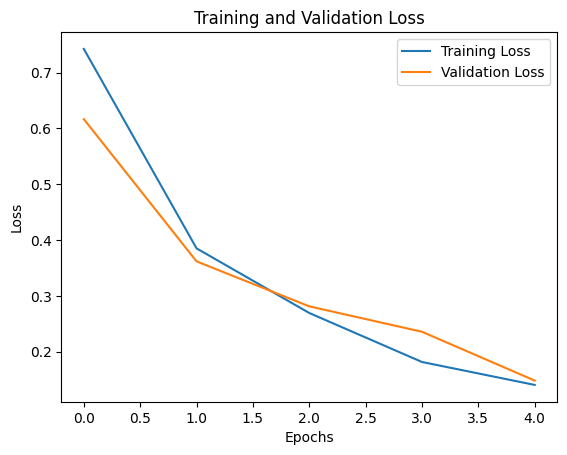

In [ ]:
# Plot training and validation loss
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

Accuracy: 98.40%


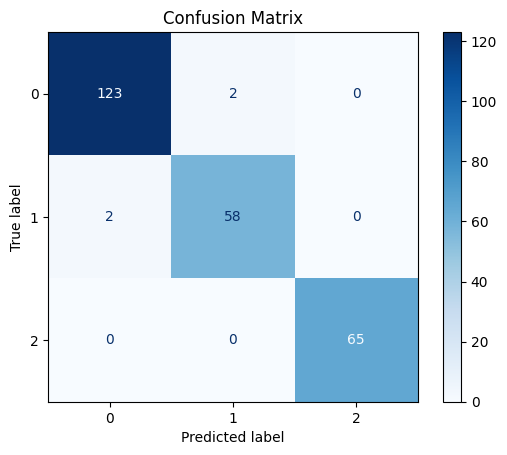

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.98      0.98      0.98       125
     Class 1       0.97      0.97      0.97        60
     Class 2       1.00      1.00      1.00        65

    accuracy                           0.98       250
   macro avg       0.98      0.98      0.98       250
weighted avg       0.98      0.98      0.98       250



In [ ]:
# Evaluate Model
test_loader = DataLoader(TensorDataset(X_test_tensor, Y_test_tensor), batch_size=best_bs, shuffle=False)
evaluate_model(model, test_loader)